In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import local_helpers as lh
import pingouin as pg
import math

# Time demand patterns
In this notebook we want to examine how the demand for the bike rentals varies over time.

In [8]:
sns.set_theme(style="darkgrid", rc={'figure.figsize': (9, 5)})

# Global variables
df_boston = lh.load_prepared_data()

## General Overview of rentals per day over complete year
In this graph we see all rentals of the year for every day. In addition to that on the second y-axis the maximal temperature of each day is sketched. The max temperature and the number of rentals correlate mostly. An exception is the spring. Even though the temperature rises, the number of rental only increases slowly, until mid of april, then the rentals grow significantly.

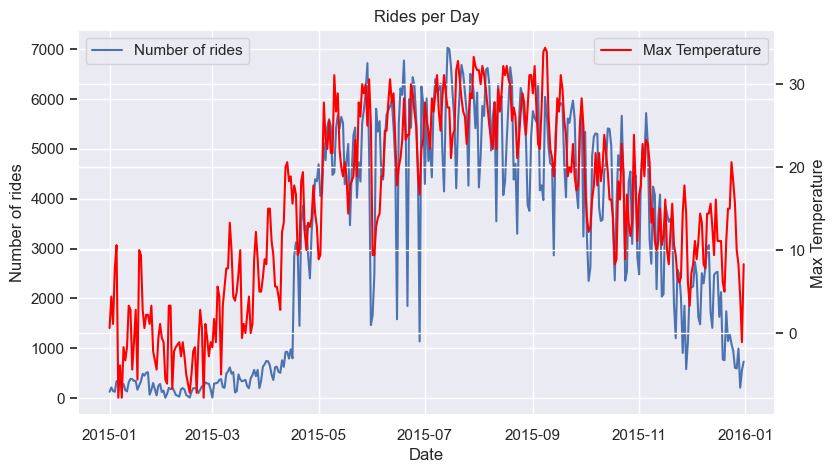

In [20]:
# Data
demand_series = df_boston.groupby(df_boston['start_time'].dt.date).size()
demand_series.index = pd.to_datetime(demand_series.index, format='%Y-%m-%d')

max_temp_day = df_boston.groupby(df_boston['start_time'].dt.date)
max_temp_day.index = pd.to_datetime(demand_series.index, format='%Y-%m-%d')

# Graph
fig = plt.figure()
ax1 = sns.lineplot(data=demand_series, legend=True)
ax1.set(xlabel='Date', ylabel='Number of rides', title='Rides per Day')
ax1.set_ylabel('Number of rides')
ax1.legend(['Number of rides'], loc="upper left")
ax2 = ax1.twinx()

sns.lineplot(data=max_temp_day['max_temp'].max('max_temp'), ax=ax2, color='red', legend=True)
ax2.set_ylabel('Max Temperature')
ax2.legend(['Max Temperature'], loc="upper right")

## Rentals per weekday over complete year
This graph shows the number of rentals for every weekday summed over the compete year. We can see, that the highest demand is on thursday and the number of rentals decreases on the weekend

[Text(0.5, 0, 'Weekday'),
 Text(0, 0.5, 'Number of rides'),
 Text(0.5, 1.0, 'Rides per Month')]

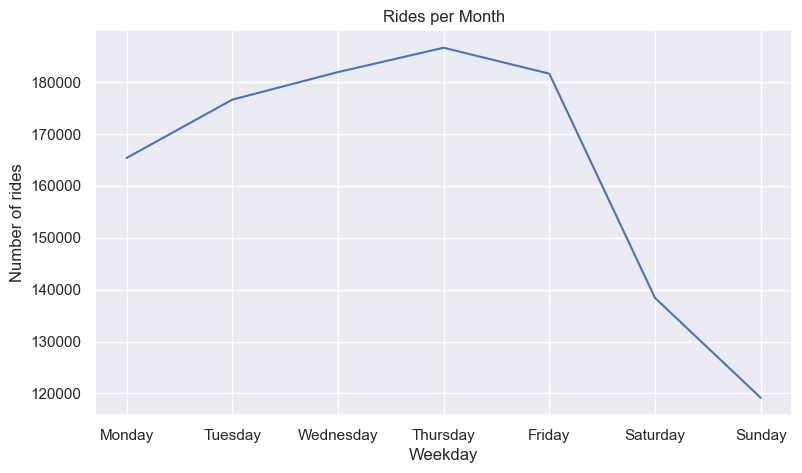

In [10]:
# Data
demand_weekday = df_boston.groupby(df_boston['start_time'].dt.day_name(), sort=True)
grouped_weekdays = demand_weekday.size().reindex(lh.days)

# Graph
ax = sns.lineplot(data=grouped_weekdays)
ax.set_xticks(grouped_weekdays.index)
ax.set(xlabel='Weekday', ylabel='Number of rides', title='Rides per Month')

## Share of rentals per weekday for every month
In addition to the graph above, we show in this graph the share of rentals for every weekday of the week grouped by the different months over the complete year.

[Text(0, 0.5, 'Percent of rentals of the week'), Text(0.5, 0, 'Weekdays')]

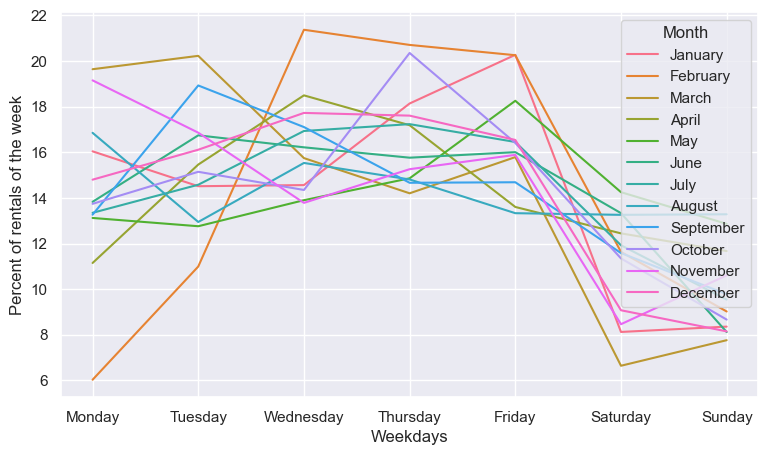

In [11]:
df_rentals_month_weekday = df_boston.copy()

# Add Column Month with the month of each ride
df_rentals_month_weekday['Month'] = df_rentals_month_weekday['start_time'].dt.month_name()

# Add Column Weekday with the weekday of each ride
df_rentals_month_weekday['Weekday'] = df_rentals_month_weekday['start_time'].dt.day_name()

# Group all rides of the year by Month and Weekday
df_rentals_month_weekday = df_rentals_month_weekday.groupby(['Month', 'Weekday']).size().reset_index(name='num_rides')

summ = df_rentals_month_weekday.groupby('Month')['num_rides'].sum()
df_rentals_month_weekday["percent"] = df_rentals_month_weekday.apply(
    lambda x: (x['num_rides'] / summ[x['Month']]) * 100, axis=1)

# Transform dtype from object to category
df_rentals_month_weekday.Weekday = pd.Categorical(df_rentals_month_weekday.Weekday, categories=lh.days)
df_rentals_month_weekday = df_rentals_month_weekday.sort_values('Weekday')

# Transform dtype from object to category
df_rentals_month_weekday.Month = pd.Categorical(df_rentals_month_weekday.Month, categories=lh.months)
df_rentals_month_weekday = df_rentals_month_weekday.sort_values('Month')

ax = sns.lineplot(data=df_rentals_month_weekday, x='Weekday', y='percent', hue='Month')
ax.set(ylabel='Percent of rentals of the week', xlabel='Weekdays')

## Rental by UserType by month
Here we group the rentals by month and user type. The proportion is mostly subscriber 64%-70%, only in february is an exception where the share of subscriber increases to 77%.

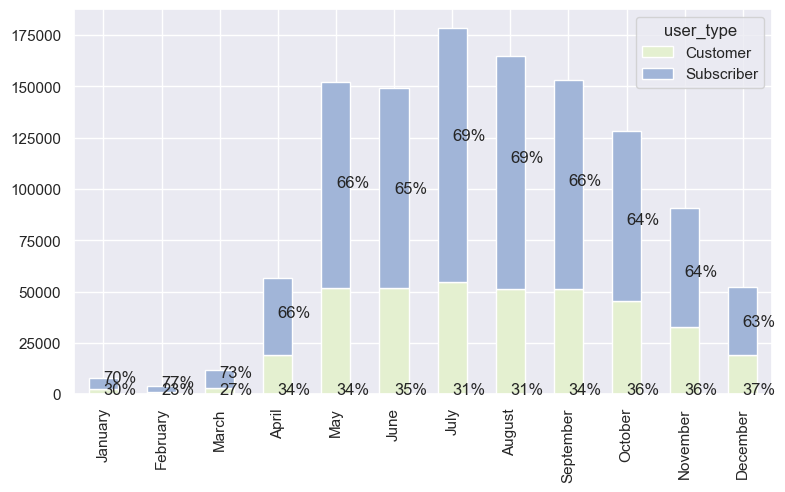

In [12]:
# The grouped pivot table is unstacked, so that every user_type gets a table in a dataframe
months_by_user_type = df_boston.groupby([df_boston["start_time"].dt.month, 'user_type']).size().unstack()
months_by_user_type.index = lh.months

months_by_user_type.plot(kind='bar', stacked=True, color={'Subscriber': '#A1B5D8', 'Customer': '#E4F0D0'})

for index, row in months_by_user_type.iterrows():
    sum = row['Customer'] + row['Subscriber']

    plt.text(x=lh.months.index(index), y=0, s=str(round(row['Customer'] / sum * 100)) + "%")
    plt.text(x=lh.months.index(index), y=row['Subscriber'], s=str(round(row['Subscriber'] / sum * 100)) + "%")

## Rental by Point of Day
In this graph we divided the day into four parts, morning (6-11 oclock), afternoon (12 - 18 oclock), evening (19 - 23 oclock) and night (0 - 5 oclock). And compared the shares of all rentals for the point of day over all months. The proportions only

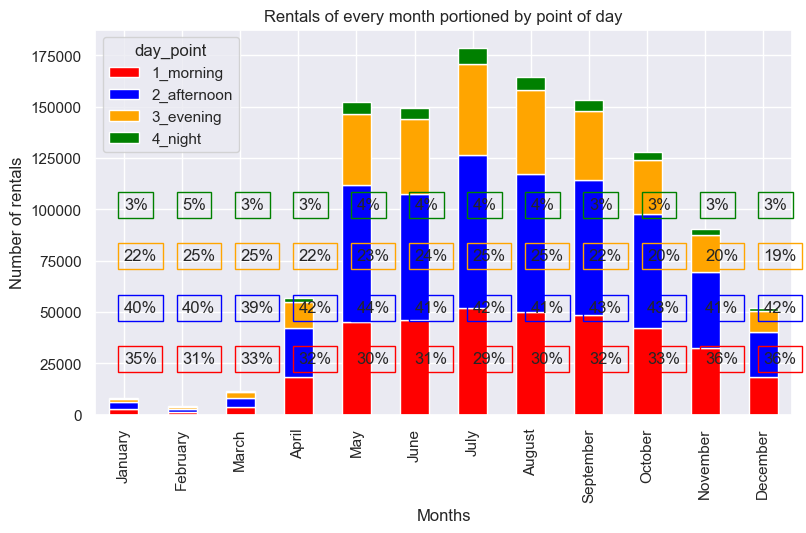

In [13]:
with_point_day = df_boston.copy()
with_point_day["day_point"] = with_point_day["start_time"].dt.hour.apply(lambda x: lh.get_point_of_day(x))

with_point_day = with_point_day.groupby([df_boston["start_time"].dt.month, 'day_point']).size().unstack()
with_point_day.index = lh.months

with_point_day.plot(kind='bar', stacked=True,
                    color={'1_morning': 'red', '2_afternoon': 'blue', '3_evening': 'orange', '4_night': 'green', })

# Graph props
plt.title("Rentals of every month portioned by point of day")
plt.xlabel("Months")
plt.ylabel("Number of rentals")

for index, row in with_point_day.iterrows():
    sum = row['1_morning'] + row['2_afternoon'] + row['3_evening'] + row['4_night']

    # The y values are constant, because the values in Febr. are so small, that the text would overlap when it's centered in the bars height
    plt.text(x=lh.months.index(index), y=25000, s=str(round(row['1_morning'] / sum * 100)) + "%",
             bbox=dict(facecolor='none', edgecolor='red'))
    plt.text(x=lh.months.index(index), y=50000, s=str(round(row['2_afternoon'] / sum * 100)) + "%",
             bbox=dict(facecolor='none', edgecolor='blue'))
    plt.text(x=lh.months.index(index), y=75000, s=str(round(row['3_evening'] / sum * 100)) + "%",
             bbox=dict(facecolor='none', edgecolor='orange'))
    plt.text(x=lh.months.index(index), y=100000, s=str(round(row['4_night'] / sum * 100)) + "%",
             bbox=dict(facecolor='none', edgecolor='green'))

Text(0, 0.5, 'Share of rentals in %')

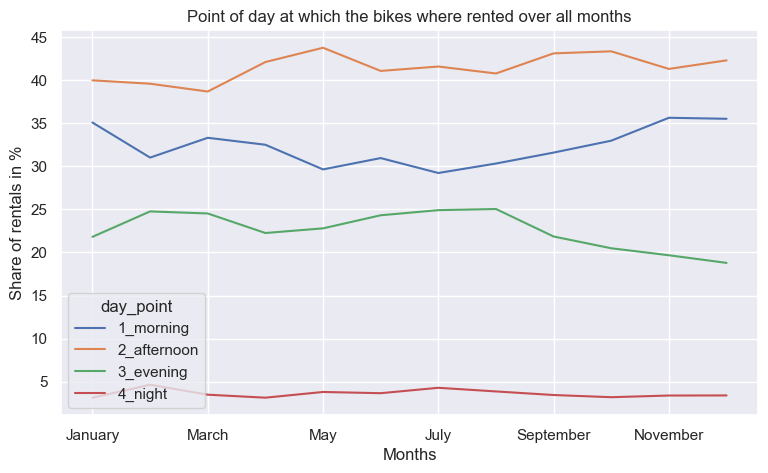

In [14]:
# For each value calculate the share by dividing the value by the sum of complete row
point_of_days_without_sum = with_point_day.loc[:, "1_morning":"4_night"].div(with_point_day.sum(axis=1), axis=0).mul(
    100)
point_of_days_without_sum.index = lh.months
point_of_days_without_sum.plot(kind='line')

# Graph props
plt.title("Point of day at which the bikes where rented over all months")
plt.xlabel("Months")
plt.ylabel("Share of rentals in %")

## Rentals by temperature level

temperature
1_very_hot      66319
2_hot          176494
3_good         464504
4_cold         279464
5_very_cold     98546
dtype: int64


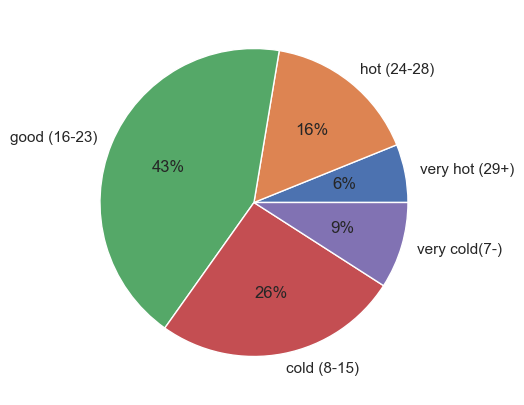

In [15]:
temperature_level = df_boston.copy()
temperature_level["temperature"] = df_boston.apply(
    lambda x: lh.get_level_of_temperature(lh.get_middle_of_two_numbers(x["min_temp"], x["max_temp"])), axis=1)

grouped_by_temperature = temperature_level.groupby(temperature_level["temperature"]).size()

print(grouped_by_temperature)

plt.pie(grouped_by_temperature.values, labels=lh.temperature_points, autopct='%.0f%%')
plt.show()

## Average Rentals/Day at every temperature level

In [16]:
grouped_by_temperature_an_date = temperature_level.groupby(
    [temperature_level["temperature"], temperature_level["start_time"].dt.weekday]).size()

# Build a table from group series in order to access the count of days per temperature and the average num of rentals
rentals_every_day_by_temperature = grouped_by_temperature_an_date.reset_index(name="rentals every weekday")
rentals_every_day_by_temperature = rentals_every_day_by_temperature.drop(columns=["start_time"])

# Group the rentals by temp and calculate the mean for all days of the temperature
average_rent_per_temperature_day = rentals_every_day_by_temperature.groupby(
    rentals_every_day_by_temperature["temperature"]).mean(numeric_only=True)

print(average_rent_per_temperature_day)

             rentals every weekday
temperature                       
1_very_hot             9474.142857
2_hot                 25213.428571
3_good                66357.714286
4_cold                39923.428571
5_very_cold           14078.000000


## Average Rentals/Hour at every temperature level

In [17]:
grouped_by_temperature_an_hour = temperature_level.groupby(
    [temperature_level["temperature"], temperature_level["start_time"].dt.hour]).size()

# Build a table from group series in order to access the count of hours per temperature and the average num of rentals
rentals_every_hour_by_temperature = grouped_by_temperature_an_hour.reset_index(name='rentals every hour')
rentals_every_hour_by_temperature = rentals_every_hour_by_temperature.drop(columns=["start_time"])

# Group the rentals by temp and calculate the mean for all hours of the temperature
average_rent_per_temperature_hour = rentals_every_hour_by_temperature.groupby(
    rentals_every_hour_by_temperature["temperature"]).mean(numeric_only=True)

print(average_rent_per_temperature_hour)

             rentals every hour
temperature                    
1_very_hot          4421.266667
2_hot               7353.916667
3_good             19354.333333
4_cold             11644.333333
5_very_cold         4106.083333


In [18]:
# Setup Demand as no of bikes rented in the current hour
df_demand = df_boston.resample(rule='H', on='start_time').size().reset_index(name='demand')
df_demand.columns = ['date_time', 'demand']
df_demand.head()

# Include Weather Data
df_weather = pd.read_csv('./data/weather_hourly_boston.csv')

df_weather.head()
df_weather['date_time'] = pd.to_datetime(df_weather['date_time'], format='%Y-%m-%d %X')
df_demand = df_demand.merge(df_weather, how = 'inner', on = 'date_time')
df_demand.head()

# Calculate Demand Change
df_demand['demand_h-1'] = df_demand['demand'].shift(periods=1)

# Remove first two lines because no trailing
df_demand = df_demand[2::]

df_demand = df_demand[df_demand['demand_h-1'] != 0.0]

df_demand['demand_change_h-1'] = df_demand.apply(lambda x: x['demand'] / x['demand_h-1'], axis=1)

# Remove all lines with infinity to not break further plotting
df_demand = df_demand[df_demand['demand_change_h-1'] != math.inf]
df_rain_demand = df_demand.copy()
df_rain_demand['rain_hour_before'] = df_demand['precip'].shift(periods=1)
df_rain_demand = df_rain_demand[1::]

df_rain_demand_filtered = df_rain_demand[df_rain_demand.apply(lambda x: (x["rain_hour_before"] == 1.0 and x["precip"] == 0.0), axis=1)]
df_not_rain_demand_filtered = df_rain_demand[df_rain_demand.apply(lambda x: (x["rain_hour_before"] == 0.0 and x["precip"] == 1.0), axis=1)]

print(df_rain_demand_filtered["demand_change_h-1"].mean())


1.3056816624855876


### Case 1: Currently not raining, it rained the hour before
A 33% increase of rentals: Possible explanation, people see that it stopped raining and start rental.

###

### Case 2: Currently raining, it did not rain the hour before
A 30% increase of rentals: Possible explanation, people see that it was dry, start rental and then it starts raining.

In [19]:
pg.compute_effsize(df_demand['precip'], df_demand['demand_change_h-1'], eftype='eta-square')

0.1368921723414819

## How to interpret the eta coefficient:
.01: Small effect size
.06: Medium effect size
.14 or higher: Large effect size

Because of eta-coefficient of 0.1388639157887471 we have a medium/large dependency between the demand change and the precip
